[View in Colaboratory](https://colab.research.google.com/github/kyokicchi/kaggle_codes/blob/master/trainXGBmodel.ipynb)

In [4]:
!pip install --upgrade xgboost

    100% |████████████████████████████████| 15.8MB 702kB/s 
  Found existing installation: xgboost 0.7.post4
    Uninstalling xgboost-0.7.post4:
      Successfully uninstalled xgboost-0.7.post4


In [17]:
import xgboost as xgb
import numpy as np
import pandas as pd
from google.colab import drive
from google.colab import files
import scipy.stats as st
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, mean_squared_error
import pickle
import matplotlib.pyplot as plt
%matplotlib inline



env: JOBLIB_TEMP_FOLDER=/tmp


In [6]:
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [7]:
%cd ../content/gdrive/My Drive/projects/
%ls

/content/gdrive/My Drive/projects
model_LGB.sav  model_XGB.sav  user_train_wip.csv


In [0]:
s_data = 'user_train_wip.csv'
s_col_tgt = 'totals.transactionRevenue_sum'
l_col_drop = ['date_min', 'date_max',s_col_tgt]
filename = 'model_XGB.sav'

In [9]:
%%time
df_train = pd.read_csv(s_data, index_col = 0)
df_y = df_train[s_col_tgt]
df_x = df_train.drop(l_col_drop, axis=1)

<string>:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


CPU times: user 10.4 s, sys: 2.55 s, total: 12.9 s
Wall time: 14.8 s


In [10]:
%%time
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y)
x_eval, x_valid, y_eval, y_valid = train_test_split(x_test, y_test)


CPU times: user 1.82 s, sys: 540 ms, total: 2.36 s
Wall time: 2.36 s


In [0]:
%env JOBLIB_TEMP_FOLDER=/tmp

model = xgb.XGBRegressor()
params = {'max_depth': [2,4,6]}

cv = model_selection.GridSearchCV(
                  model,
                  params,
                  cv=3,
                  n_jobs=-1,
                  verbose=2)


In [18]:
%%time
fit_params = {"early_stopping_rounds": 10,
              "eval_set": [[x_test, y_test]]}

cv.fit(x_train, y_train,,
                  fit_params=fit_params)


Fitting 10 folds for each of 3 candidates, totalling 30 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:585: DeprecationWarning: "fit_params" as a constructor argument was deprecated in version 0.19 and will be removed in version 0.21. Pass fit parameters to the "fit" method instead.
  '"fit" method instead.', DeprecationWarning)


[CV] max_depth=2 .....................................................
[CV] max_depth=2 .....................................................
[0]	validation_0-rmse:2.63035
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:2.5733
[0]	validation_0-rmse:2.63003
Will train until validation_0-rmse hasn't improved in 10 rounds.
[2]	validation_0-rmse:2.52307
[1]	validation_0-rmse:2.57168
[3]	validation_0-rmse:2.48217
[2]	validation_0-rmse:2.52477
[4]	validation_0-rmse:2.44602
[3]	validation_0-rmse:2.48336
[5]	validation_0-rmse:2.41472
[6]	validation_0-rmse:2.38815
[4]	validation_0-rmse:2.44675
[7]	validation_0-rmse:2.36428
[5]	validation_0-rmse:2.41492
[8]	validation_0-rmse:2.34833
[6]	validation_0-rmse:2.38964
[9]	validation_0-rmse:2.33037
[7]	validation_0-rmse:2.36781
[10]	validation_0-rmse:2.31196
[8]	validation_0-rmse:2.34804
[11]	validation_0-rmse:2.3007
[9]	validation_0-rmse:2.32704
[12]	validation_0-rmse:2.28654
[10]	validation_0-rmse:2.30828
[13]	v

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 74.6min finished


[0]	validation_0-rmse:2.61292
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:2.53109
[2]	validation_0-rmse:2.46135
[3]	validation_0-rmse:2.40776
[4]	validation_0-rmse:2.35943
[5]	validation_0-rmse:2.32204
[6]	validation_0-rmse:2.29111
[7]	validation_0-rmse:2.26369
[8]	validation_0-rmse:2.24098
[9]	validation_0-rmse:2.21408
[10]	validation_0-rmse:2.19859
[11]	validation_0-rmse:2.18654
[12]	validation_0-rmse:2.17441
[13]	validation_0-rmse:2.16042
[14]	validation_0-rmse:2.1492
[15]	validation_0-rmse:2.14013
[16]	validation_0-rmse:2.1323
[17]	validation_0-rmse:2.12276
[18]	validation_0-rmse:2.11483
[19]	validation_0-rmse:2.11111
[20]	validation_0-rmse:2.10648
[21]	validation_0-rmse:2.09844
[22]	validation_0-rmse:2.09243
[23]	validation_0-rmse:2.0905
[24]	validation_0-rmse:2.08685
[25]	validation_0-rmse:2.08204
[26]	validation_0-rmse:2.07932
[27]	validation_0-rmse:2.07564
[28]	validation_0-rmse:2.07351
[29]	validation_0-rmse:2.07128
[30]	validation_0-

KeyboardInterrupt: ignored

In [19]:
print(cv.best_params_, cv.best_score_)

{'max_depth': 4} 0.3925459226055601


In [21]:
model = xgb.XGBRegressor(**cv.best_params_)
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [22]:
%%time
pickle.dump(model, open(filename, 'wb'))

CPU times: user 1.94 ms, sys: 1e+03 µs, total: 2.94 ms
Wall time: 194 ms


In [0]:
files.download(filename) 

In [24]:
pred = model.predict(x_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
print(rmse)

2.0183461458875516


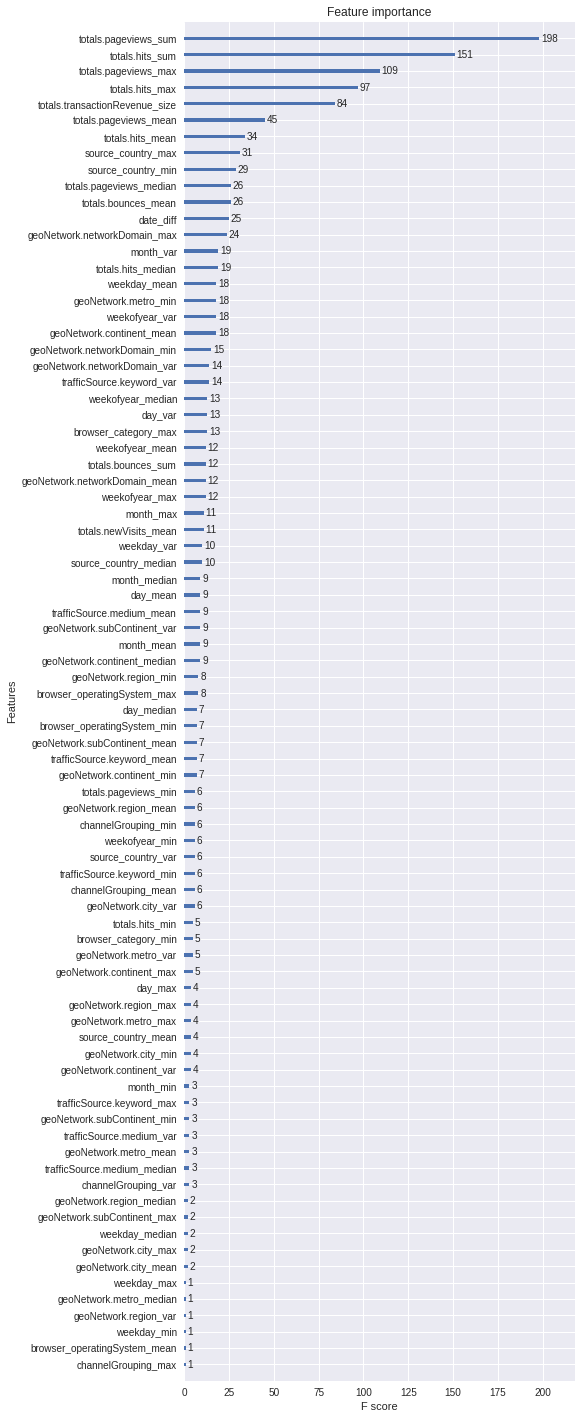

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(7, 25))
xgb.plot_importance(model, ax=ax)
plt.show()